In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from geopy.distance import geodesic

# Load CitiBike data
citibike_df = pd.read_csv("/Users/shashankhmg/Documents/AXA-Casestudy/Data-Science-Challenge/data/processed/cleaned_citibike_data.csv")
# Load NYPD accident data
nypd_df = pd.read_csv("/Users/shashankhmg/Documents/AXA-Casestudy/Data-Science-Challenge/data/processed/nypd_data_cleaned.csv")  # Replace with actual path


/var/folders/tw/yc01l_99601d14ks8nxwg1dr0000gn/T/ipykernel_96404/3716683314.py:7: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  citibike_df = pd.read_csv("/Users/shashankhmg/Documents/AXA-Casestudy/Data-Science-Challenge/data/processed/cleaned_citibike_data.csv")


Assigning risk scores to each citybank station

In [2]:
import numpy as np
from scipy.spatial import cKDTree

# Filter only cyclist-related accidents
nypd_cyclist_accidents = nypd_df[
    (nypd_df["NUMBER OF CYCLIST INJURED"] > 0) | 
    (nypd_df["NUMBER OF CYCLIST KILLED"] > 0)
]

# Convert coordinates to numpy arrays for KDTree
accident_coords = np.array(list(zip(nypd_df["LATITUDE"], nypd_df["LONGITUDE"])))
station_coords = np.array(list(zip(citibike_df["start_lat"], citibike_df["start_lng"])))

# Build KDTree for fast lookup
accident_tree = cKDTree(accident_coords)

# Define search radius (in degrees, approx. 100m = 0.001 degrees)
search_radius = 0.001

# Find nearby accidents for each CitiBike station
accidents_near_station = accident_tree.query_ball_point(station_coords, search_radius)

In [3]:
# Count the number of accidents near each station
accident_counts = [len(acc) for acc in accidents_near_station]

# Assign raw accident count to CitiBike stations
citibike_df["accident_count"] = accident_counts

In [4]:
# Group by station name and sum the accident count
citybike_station_riskscore = citibike_df.groupby("start_station_name", as_index=False)["accident_count"].sum()


In [5]:
citybike_station_riskscore

,start_station_name,accident_count
0,1 Ave & E 110 St,318375
1,1 Ave & E 118 St,409952
2,1 Ave & E 16 St,801735
3,1 Ave & E 18 St,974389
4,1 Ave & E 30 St,1404586
...,...,...
2149,Wyckoff Ave & Stanhope St,247065
2150,Wyckoff St & 3 Ave,161628
2151,Wythe Ave & Metropolitan Ave,427110
2152,Wythe Ave & N 13 St,208010


In [6]:
# Risk score is calculated by penalizing stations with more than 10 accidents.
# Each accident above 10 adds a penalty weight (default = 2) to the risk score.


In [7]:
# Define penalty weight per accident (adjustable)
penalty_weight = 2  # Each extra accident above 10 increases risk score

# Apply the formula
citybike_station_riskscore["risk_score"] = (citybike_station_riskscore["accident_count"] - 10) * penalty_weight
citybike_station_riskscore["risk_score"] = citybike_station_riskscore["risk_score"].clip(lower=0)  # No negative scores


In [8]:
citybike_station_riskscore

,start_station_name,accident_count,risk_score
0,1 Ave & E 110 St,318375,636730
1,1 Ave & E 118 St,409952,819884
2,1 Ave & E 16 St,801735,1603450
3,1 Ave & E 18 St,974389,1948758
4,1 Ave & E 30 St,1404586,2809152
...,...,...,...
2149,Wyckoff Ave & Stanhope St,247065,494110
2150,Wyckoff St & 3 Ave,161628,323236
2151,Wythe Ave & Metropolitan Ave,427110,854200
2152,Wythe Ave & N 13 St,208010,416000


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the risk scores to a scale of 0 to 1 for better comparability
scaler = MinMaxScaler()
citybike_station_riskscore["normalized_risk_score"] = scaler.fit_transform(citybike_station_riskscore[["risk_score"]])


In [10]:
citybike_station_riskscore

,start_station_name,accident_count,risk_score,normalized_risk_score
0,1 Ave & E 110 St,318375,636730,0.028814
1,1 Ave & E 118 St,409952,819884,0.037102
2,1 Ave & E 16 St,801735,1603450,0.072560
3,1 Ave & E 18 St,974389,1948758,0.088186
4,1 Ave & E 30 St,1404586,2809152,0.127121
...,...,...,...,...
2149,Wyckoff Ave & Stanhope St,247065,494110,0.022360
2150,Wyckoff St & 3 Ave,161628,323236,0.014627
2151,Wythe Ave & Metropolitan Ave,427110,854200,0.038655
2152,Wythe Ave & N 13 St,208010,416000,0.018825


In [11]:
# Ensure start_station_name is present in the dataframe before merging
citibike_df = citibike_df.merge(
    citybike_station_riskscore[["start_station_name", "normalized_risk_score"]],
    on="start_station_name",
    how="left"
)

In [14]:
citibike_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,accident_count,normalized_risk_score
0,56BD148A05E26915,electric_bike,2025-01-01 22:19:06.324,2025-01-01 22:23:32.899,W 36 St & 7 Ave,6483.06,W 24 St & 7 Ave,6257.03,40.752149,-73.989539,40.744876,-73.995299,member,694,0.129075
1,700CCCDF00C08077,electric_bike,2025-01-09 15:20:43.991,2025-01-09 15:26:19.137,Broadway & E 19 St,5980.11,W 24 St & 7 Ave,6257.03,40.738290,-73.990060,40.744876,-73.995299,member,156,0.049401
2,B1A3FAFA5FE651CE,electric_bike,2025-01-01 12:54:26.571,2025-01-01 13:03:03.565,Jackson Ave & 46 Rd,6203.02,Crescent St & Broadway,6827.11,40.745248,-73.947333,40.763359,-73.928647,member,86,0.007191
3,9CB0F28054BA5EBC,electric_bike,2025-01-14 13:43:59.151,2025-01-14 13:49:04.543,Broadway & E 19 St,5980.11,W 24 St & 7 Ave,6257.03,40.738290,-73.990060,40.744876,-73.995299,member,156,0.049401
4,A1B8FDD4FAF0C2B2,electric_bike,2025-01-13 07:20:37.176,2025-01-13 07:29:18.015,Willis Ave & E 143 St,7798.02,1 Ave & E 110 St,7522.02,40.812299,-73.920370,40.792327,-73.938300,member,183,0.004156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119676,0EDA53461D0388D5,classic_bike,2025-01-24 14:46:32.047,2025-01-24 14:53:27.119,34 Ave & 31 St,6720.07,31 Ave & Steinway St,6782.01,40.759604,-73.927144,40.761149,-73.917007,member,125,0.005995
2119677,C30264245638AA98,electric_bike,2025-01-29 20:39:37.864,2025-01-29 20:43:38.814,Driggs Ave & S 2 St,5235.10,Bayard St & Leonard St,5442.05,40.712628,-73.960575,40.719156,-73.948854,member,180,0.028606
2119678,E7A2D0EC9B5197E5,electric_bike,2025-01-21 15:46:38.904,2025-01-21 15:49:19.936,W 11 St & 6 Ave,5914.03,W 10 St & Washington St,5847.06,40.735324,-73.998004,40.733424,-74.008515,casual,331,0.079116
2119679,5FF2284D69F9D931,electric_bike,2025-01-19 09:21:26.100,2025-01-19 09:31:36.489,Pleasant Ave & E 116 St,7540.05,E 80 St & 2 Ave,7121.02,40.794990,-73.933330,40.773914,-73.954395,member,251,0.033007


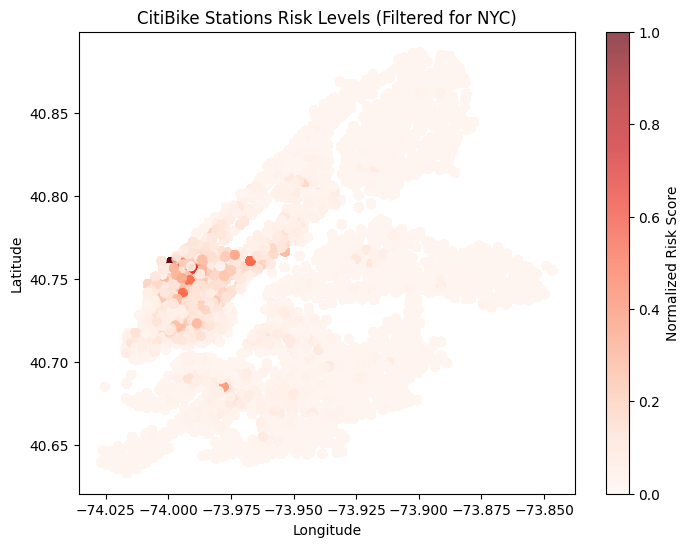

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only valid NYC coordinates
nyc_bounds = (citibike_df['start_lat'].between(40.5, 40.9)) & (citibike_df['start_lng'].between(-74.1, -73.7))
citibike_filtered = citibike_df[nyc_bounds]

plt.figure(figsize=(8, 6))
plt.scatter(citibike_filtered['start_lng'], citibike_filtered['start_lat'], 
            c=citibike_filtered['normalized_risk_score'], cmap='Reds', alpha=0.7)
plt.colorbar(label="Normalized Risk Score")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("CitiBike Stations Risk Levels (Filtered for NYC)")
plt.show()


In [18]:
def classify_risk(score):
    if score <= 0.25:
        return "Low Risk"
    elif score <= 0.50:
        return "Moderate Risk"
    elif score <= 0.75:
        return "High Risk"
    else:
        return "Very High Risk"

citibike_df["risk_level"] = citibike_df["normalized_risk_score"].apply(classify_risk)

In [20]:
citibike_df["risk_level"].value_counts()

risk_level
Low Risk          2015676
Moderate Risk       91348
Very High Risk       6923
High Risk            5734
Name: count, dtype: int64

In [21]:
citibike_df.to_csv('/Users/shashankhmg/Documents/AXA-Casestudy/Data-Science-Challenge/data/model_data/model_data.csv')